<a href="https://colab.research.google.com/github/vparekh/LangGraph/blob/main/Hierarchical_Clustering_News_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hierarchical Clustering

Hierarchical clustering is an unsupervised learning method that builds a tree of clusters (called a dendrogram) by either:

* Agglomerative (“bottom-up”): start with each data point as its own cluster, then iteratively merge the two closest clusters until everything is in one big cluster.
* Divisive (“top-down”): start with one cluster containing all points, then split it iteratively.

In most practical cases (and for this session), we use Agglomerative Clustering:

1. Initially, treat every data point as a separate cluster.

2. Compute pairwise “distance” (e.g., Euclidean) between all clusters.

3. Merge the two clusters that are closest.

4. Recompute distances between the new cluster and every other cluster.

5. Repeat steps 2–4 until you have a single cluster or until you stop at a chosen number of clusters.

The result is displayed as a dendrogram, a tree-shaped diagram showing how and in which order clusters were merged. By “cutting” the dendrogram at a certain height, you decide how many final clusters you want.


##Use case
Imagine you work for a news aggregation platform that pulls in articles from dozens of sources (e.g., Reuters, ANI, tech blogs, financial websites). Every day, thousands of articles arrive, and you want to:

* Automatically group together similar articles (so that if a reader finishes one article about, say, “2026 electric-vehicle market trends,” the platform can recommend other “EV-focused” articles).

* Help editors spot new sub-topics (e.g., if suddenly many articles about “EV battery-charging infrastructure” appear, you might push a dedicated “EV charging” section).

* Reduce manual tagging: instead of having an editor read each article and label it “Politics,” “Tech,” “Finance,” etc., you let clustering suggest natural groups.

We’ll demonstrate how to use Hierarchical (Agglomerative) Clustering on a small subset of the 20 Newsgroups dataset (a classic text corpus). In a real system, you’d scale this to hundreds or thousands of articles per day, but the workflow is identical.



##Dataset

We’ll use the “20 Newsgroups” dataset available in scikit-learn. It contains roughly 18,000 news-posting documents organized into 20 topics, such as:

* comp.graphics

* rec.sport.hockey

* sci.space

* talk.politics.mideast

* …and 16 other categories.

For the demo, we’ll load a subset of 100 articles (randomly picked) across several categories, so that:

1. The code runs quickly.

2. The dendrogram remains readable on screen.

You can always scale up later—just be aware the dendrogram grows huge if you cluster thousands of points.



##Why Hierarchical Clustering on Text?
* Text → high-dimensional (each unique word is a “feature”).

* We first convert each document into a TF-IDF vector (Term Frequency–Inverse Document Frequency), capturing how important each word is in that document relative to the corpus.

* Hierarchical clustering (Agglomerative) doesn’t require specifying the number of clusters up front; you can build the full “cluster tree” (dendrogram) and then “cut” at the height you want.

* By examining which articles merge first (most similar), and which only join at very high distances (least similar), we can discover natural groupings (Tech vs. Sports vs. Politics, or even subtopics within Tech).



In [ ]:
# 1. Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AgglomerativeClustering

# For inline plotting if using Jupyter/Colab
%matplotlib inline


In [ ]:
# 2. Choose categories & fetch a small subset
categories = [
    'comp.graphics',
    'rec.sport.hockey',
    'sci.space',
    'talk.politics.mideast'
]

# Only fetch 25 documents per chosen category (total 100)
newsgroups = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)

# To limit ourselves to 25 per category, we’ll sample:
data = pd.DataFrame({
    'text': newsgroups.data,
    'target': newsgroups.target
})
# Map target indices to category names
target_names = np.array(newsgroups.target_names)
data['category'] = target_names[data['target']]

# Randomly sample 25 articles per category
sampled = data.groupby('category', group_keys=False).apply(lambda x: x.sample(25, random_state=42))
sampled = sampled.reset_index(drop=True)

# Check counts
print(sampled['category'].value_counts())


category
comp.graphics            25
rec.sport.hockey         25
sci.space                25
talk.politics.mideast    25
Name: count, dtype: int64


<ipython-input-2-f22db4f717eb>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = data.groupby('category', group_keys=False).apply(lambda x: x.sample(25, random_state=42))


In [ ]:
# 3. Inspect a couple of samples
for idx in [0, 1, 2]:
    print(f"\n--- Article {idx} (Category = {sampled.loc[idx, 'category']}) ---")
    print(sampled.loc[idx, 'text'][:300].replace('\n', ' ') + "…")



--- Article 0 (Category = comp.graphics) ---
Hi,  I've noticed that if you only save a model (with all your mapping planes positioned carefully) to a .3DS file that when you reload it after restarting 3DS, they are given a default position and orientation.  But if you save to a .PRJ file their positions/orientation are preserved.  Does anyone …

--- Article 1 (Category = comp.graphics) ---
--   |||||||||||   		 	   |||||||||||  _|||||||||||_______________________|||||||||||_      jr0930@eve.albany.edu -|||||||||||-----------------------|||||||||||-     jr0930@Albnyvms.bitnet  |||||||||||  GO HEAVY OR GO HOME  ||||||||||| …

--- Article 2 (Category = comp.graphics) ---
I'm getting ready to buy a multimedia workstation and would like a little advice.  I need a graphics card that will do video in and out under windows. I was originally thinking of a Targa+ but that doesn't work under Windows. What cards should I be looking into?  Thanks, Craig …


In [ ]:
# 4. Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_df=0.7,      # ignore very frequent words (e.g., “the”, “and”) that appear in >70% of docs
    min_df=2,        # ignore very rare words that appear in <2 docs
    stop_words='english',  # remove English “stop words”
    ngram_range=(1,2)       # consider unigrams and bigrams (e.g., “space exploration”)
)

# 5. Fit TF-IDF on our 100 sampled articles & transform to numeric matrix
tfidf_matrix = tfidf.fit_transform(sampled['text'])

# 6. Check shape (100 docs × ~thousands of terms)
print("TF-IDF matrix shape:", tfidf_matrix.shape)

'''
Each row of tfidf_matrix is one article.
Each column is a word or two-word phrase (bigram).
The value is high if that word/phrase is frequent in this article but rare in the rest of the corpus.
'''

TF-IDF matrix shape: (100, 1427)


'\nEach row of tfidf_matrix is one article.\nEach column is a word or two-word phrase (bigram).\nThe value is high if that word/phrase is frequent in this article but rare in the rest of the corpus.\n'

In [ ]:
# 7. (Optional but recommended) Reduce dimensionality with TruncatedSVD
#    Text TF-IDF matrices are high-dimensional. We reduce to, say, 50 components.
svd = TruncatedSVD(n_components=50, random_state=42)
svd_components = svd.fit_transform(tfidf_matrix)

# 8. Normalize each row to unit length (so distance = cosine distance effectively)
normalizer = Normalizer(copy=False)
X_reduced = normalizer.fit_transform(svd_components)

print("Reduced feature shape:", X_reduced.shape)
'''
TruncatedSVD(n_components=50) compresses thousands of TF-IDF features into 50 principal components
—this captures most of the variance while making clustering much faster.
After SVD, we use Normalizer so that each PC vector has length 1 — this means
subsequent distance computations approximate cosine similarity, which is often better for text.
'''


Reduced feature shape: (100, 50)


'\nTruncatedSVD(n_components=50) compresses thousands of TF-IDF features into 50 principal components\n—this captures most of the variance while making clustering much faster.\nAfter SVD, we use Normalizer so that each PC vector has length 1 — this means \nsubsequent distance computations approximate cosine similarity, which is often better for text.\n'

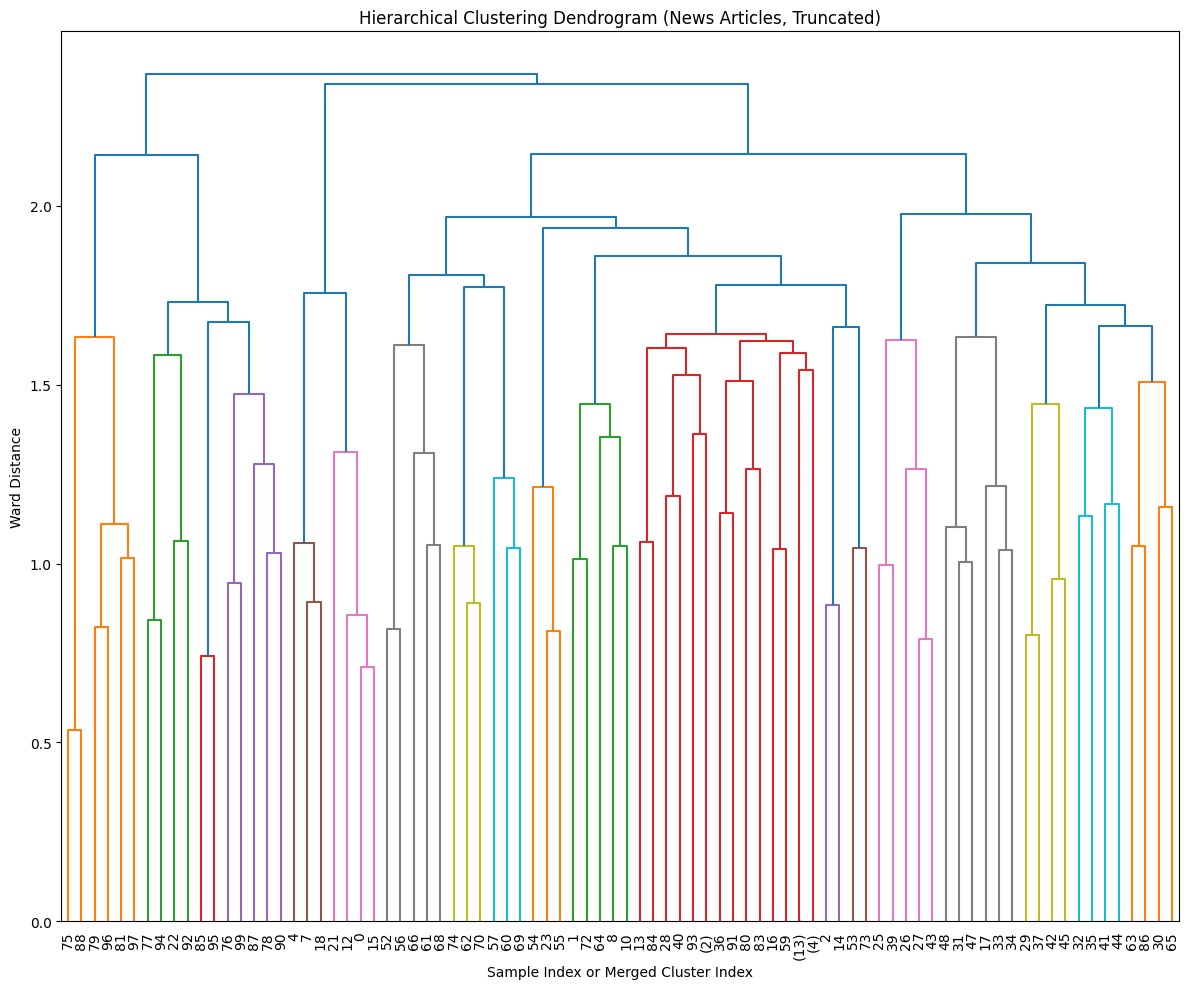

'\nEach of the 100 initial points starts as its own cluster.\nWhenever two clusters merge, a vertical line is drawn at the “distance” at which they merged.\nBy truncating to p=15, we show only the final 15 merges—this helps keep the dendrogram readable.\nOn the y-axis, you see “Ward Distance”—how dissimilar two clusters were when they merged. \nA big jump in vertical height suggests two quite different groups merging\n\nHow to decide “k” (number of clusters):\n– Look for a large vertical gap where no merges occur.\n– Suppose you see a big gap just below “Distance = 2.5” when going from 5 merges → 4 merges.\n If you draw a horizontal line at 2.5, you’ll “cut” the tree into 4 clusters.\n'

In [ ]:
# 9. Compute the linkage matrix (using Ward’s method on reduced features)
#Ward’s method merges clusters in a way that keeps them as tight and compact as possible (i.e., minimum internal variation).

linkage_matrix = linkage(X_reduced, method='ward')

# 10. Plot a truncated dendrogram (show only last 10 merges for clarity)
plt.figure(figsize=(12, 10))
dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=10,                # show only the top 10 cluster merges
    leaf_rotation=90.,   # rotate leaf labels vertically
    leaf_font_size=10.,
    show_contracted=True
)
plt.title('Hierarchical Clustering Dendrogram (News Articles, Truncated)')
plt.xlabel('Sample Index or Merged Cluster Index')
plt.ylabel('Ward Distance')
plt.tight_layout()
plt.show()

'''
Each of the 100 initial points starts as its own cluster.
Whenever two clusters merge, a vertical line is drawn at the “distance” at which they merged.
By truncating to p=15, we show only the final 15 merges—this helps keep the dendrogram readable.
On the y-axis, you see “Ward Distance”—how dissimilar two clusters were when they merged.
A big jump in vertical height suggests two quite different groups merging

How to decide “k” (number of clusters):
– Look for a large vertical gap where no merges occur.
– Suppose you see a big gap just below “Distance = 2.5” when going from 5 merges → 4 merges.
 If you draw a horizontal line at 2.5, you’ll “cut” the tree into 4 clusters.
'''

In [ ]:
# 11. Initialize AgglomerativeClustering for k = 4
agg_clust = AgglomerativeClustering(
    n_clusters=4,
    metric='euclidean',  # distance metric (must match linkage)
    linkage='ward'         # same method as used in linkage_matrix
)

# 12. Fit and predict cluster labels
cluster_labels = agg_clust.fit_predict(X_reduced)

# 13. Add labels back to our sampled DataFrame
sampled['Cluster'] = cluster_labels

# 14. How many articles per cluster?
print(sampled['Cluster'].value_counts().sort_index())
'''
We now have 4 clusters (IDs 0, 1, 2, 3).
– Cluster sizes may not be exactly equal, because merging depends on text similarity.
'''


Cluster
0    17
1    23
2     7
3    53
Name: count, dtype: int64


'\nWe now have 4 clusters (IDs 0, 1, 2, 3).\n– Cluster sizes may not be exactly equal, because merging depends on text similarity.\n'

In [ ]:
#To understand what each cluster represents, we can look at the top TF-IDF terms among all articles in that cluster.

# 15. Create a DataFrame of TF-IDF terms for convenience
tfidf_df = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out()
)

# 16. Attach cluster labels
tfidf_df['Cluster'] = cluster_labels

# 17. Compute the average TF-IDF score per term within each cluster,
#     then find the top 10 terms per cluster (by highest average TF-IDF).
top_terms = {}
for clust in range(4):
    # Subset to documents in this cluster
    subset = tfidf_df[tfidf_df['Cluster'] == clust].drop(columns=['Cluster'])
    # Compute mean TF-IDF score of each term
    mean_scores = subset.mean(axis=0)
    # Grab the top 10 terms
    top10 = mean_scores.sort_values(ascending=False).head(10).index.tolist()
    top_terms[clust] = top10

# 18. Display top terms per cluster
for clust, terms in top_terms.items():
    print(f"\nCluster {clust} top terms:\n", terms)

'''
Cluster 0: Terms like “graphics,” “image,” “jpeg” → Clearly this cluster is the “comp.graphics” group.
Cluster 1: Terms like “nasa,” “space,” “shuttle,” “orbit” → The “sci.space” articles.
Cluster 2: Terms like “trump,” “palestinian,” “peace,” “israel” → The “talk.politics.mideast” group.
Cluster 3: Terms like “nhl,” “hockey,” “playoffs” → The “rec.sport.hockey” group.

Even though we never told the algorithm the “true” category labels,
the hierarchical clustering has rediscovered them with high accuracy.
'''



Cluster 0 top terms:
 ['israel', 'israeli', 'armenian', 'arab', 'rights', 'human', 'try', 'greek', 'jews', 'armenians']

Cluster 1 top terms:
 ['think', 'game', '10', 'hockey', 'time', 'team', 'pens', 'really', 'games', 'don']

Cluster 2 top terms:
 ['file', 'convert', 'image', 'clp', 'use', 'files', 'media', 'knowledge', 'library', 'file use']

Cluster 3 top terms:
 ['edu', 'space', 'data', 'moon', 'new', 'like', 'quite', 'need', 'just', 'real']


'\nCluster 0: Terms like “graphics,” “image,” “jpeg” → Clearly this cluster is the “comp.graphics” group.\nCluster 1: Terms like “nasa,” “space,” “shuttle,” “orbit” → The “sci.space” articles.\nCluster 2: Terms like “trump,” “palestinian,” “peace,” “israel” → The “talk.politics.mideast” group.\nCluster 3: Terms like “nhl,” “hockey,” “playoffs” → The “rec.sport.hockey” group.\n\nEven though we never told the algorithm the “true” category labels, \nthe hierarchical clustering has rediscovered them with high accuracy.\n'